In [1]:
from pandas_datareader import data as datareader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
import shap

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [3]:
# tickers = ['SPX', 'IBM', 'TSLA', 'OIL', 'MSFT', 'AAPL', 'AMZN']
tickers = ['AAPL']

start_date = '2000-01-01'
end_date = '2020-01-01'

datasets = {}
for ticker in tickers:
    data = datareader.DataReader(ticker, 'yahoo', start_date, end_date)
    datasets[ticker] = data

# Feature extraction

In [4]:
# ! pip3.6 install --upgrade mlfinlab&nstall numba
# ! pip3.6 install TA-Lib

In [5]:
from mlfinlab.features.fracdiff import frac_diff_ffd
from utils import get_meta_barier, getDailyVol

In [6]:
import talib

In [7]:
% matplotlib inline

In [8]:
WINDOW = 14
HORIZON = 7

In [9]:
data = datasets[tickers[0]]
data.columns = [c.lower() for c in data.columns]
frac_diff_series = frac_diff_ffd(pd.DataFrame(data['close']), 0.5, thresh=1e-4)

In [10]:
frac_diff_series.shape, data.shape

((5031, 1), (5031, 6))

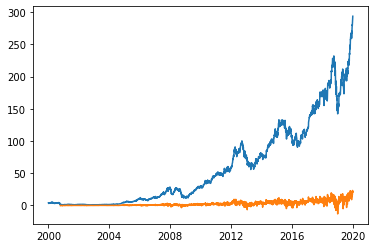

In [11]:
plt.figure()
plt.plot(data.close)
plt.plot(frac_diff_series)
plt.show()

In [12]:
data['feat_mean_frac_close'] = frac_diff_series.rolling(WINDOW).mean()
data['feat_std_frac_close'] = frac_diff_series.rolling(WINDOW).std()
data['feat_skew_frac_close'] = frac_diff_series.rolling(WINDOW).skew()
data['feat_kurt_frac_close'] = frac_diff_series.rolling(WINDOW).kurt()
data['feat_autocorr_frac_close'] = frac_diff_series.rolling(WINDOW).apply(lambda x: x.autocorr(), raw=False)

In [13]:
data['feat_RSI_close'] = talib.RSI(data.close)
data['feat_OBV_volume'] = talib.OBV(data.close, data.volume)
data['feat_ATR_close'] = talib.ATR(data.high, data.low, data.close, WINDOW)
data['feat_HT_DCPERIOD_close'] = talib.HT_DCPERIOD(data.close)
data['feat_HT_DCPHASE_close'] = talib.HT_DCPHASE(data.close)

In [14]:
data['feat_random1'] = np.random.normal(0, 1, size=(data.shape[0]))
data['feat_random2'] = np.random.uniform(0, 1, size=(data.shape[0]))
data['feat_random3'] = np.random.poisson(1, size=(data.shape[0]))
data['feat_random4'] = np.random.binomial(1, 0.5, size=(data.shape[0]))
data['feat_random5'] = np.random.logistic(0, 1, size=(data.shape[0]))

# Dataset creation

In [15]:
FEATURE_COLUMNS = [d for d in data.columns if 'feat_' in d]

In [16]:
daily_vol = getDailyVol(data.close)

In [17]:
def create_dataset(data, daily_vol):
    
    TP = 0.01
    SL = - TP

    T, P, X, Y, Y2 = [], [], [], [], []
    TIME = []
    
    for i in daily_vol.index:

        window = data.loc[i][FEATURE_COLUMNS].values

        if np.isnan(window).any():
            continue

        now = data.close[i]
        future_window = data.loc[i:i + timedelta(days=HORIZON)].close

        Ti = daily_vol.loc[i]

        min_ret_situation, take_action, timings = get_meta_barier(future_window, now, Ti, TP, SL, False)

        X.append(window)
        Y.append(min_ret_situation)
        Y2.append(take_action)
        T.append(timings)
        P.append(data.loc[i].close)
        TIME.append(i)
        
    dataset_df = pd.DataFrame(np.array(X), columns = [FEATURE_COLUMNS], index = TIME)
    dataset_df['bin'] = np.argmax(Y, axis=1)
    dataset_df['t1'] = pd.Series(dataset_df.index, index = dataset_df.index)
    dataset_df['w'] = 1. / len(Y)

    X = dataset_df[FEATURE_COLUMNS]
    Y = pd.Series(dataset_df['bin'].values.flatten().tolist(), index=X.index).to_frame('bin')
    Y['w'] = 1./Y.shape[0]
    Y['t1'] = pd.Series(Y.index, index = Y.index)
    X.columns = FEATURE_COLUMNS
    
    return X, Y, T, P

In [18]:
from datetime import datetime

In [19]:
t = datetime.strptime('2010-01-01', '%Y-%m-%d') # 2017

In [20]:
X, Y, T, P = create_dataset(data[:t], daily_vol[:t])

In [21]:
X_oos, Y_oos, T_oos, P_oos = create_dataset(data[t:], daily_vol[t:])

# Feature Importance

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import log_loss, accuracy_score
from sklearn import model_selection

from scipy.cluster.hierarchy import linkage, fcluster
from itertools import product

In [23]:
def featImpMDI(fit, featNames):
    # feat importance based on IS mean impurity reduction
    df0 = {i:tree.feature_importances_ for i, tree in enumerate(fit.estimators_)}
    
    
    df0 = pd.DataFrame.from_dict(df0, orient='index')
    df0.columns = featNames

    df0 = df0.replace(0, np.nan) # because max_features=1
    imp = pd.concat({'mean': df0.mean(), 'std': df0.std() * df0.shape[0] ** -.5}, axis=1)
    imp /= imp['mean'].sum()

    return imp

In [24]:
def featImpMDA(clf, X, y, cv, sample_weight, t1, pctEmbargo, scoring='accuracy'):
    # feat importance based on OOS score reduction
    if scoring not in ['neg_log_loss','accuracy']:
        raise Exception('wrong scoring method.')

    cvGen=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged cv
    scr0,scr1=pd.Series(),pd.DataFrame(columns=X.columns)

    for i,(train,test) in enumerate(cvGen.split(X=X)):
        
        X0,y0,w0=X.iloc[train,:],y.iloc[train],sample_weight.iloc[train]
        X1,y1,w1=X.iloc[test,:],y.iloc[test],sample_weight.iloc[test]
        fit=clf.fit(X=X0,y=y0,sample_weight=w0.values)
        pred=fit.predict(X1)
        scr0.loc[i]=accuracy_score(y1,pred,sample_weight=w1.values)
        for j in X.columns:

            X1_=X1.copy(deep=True)
            np.random.shuffle(X1_[j].values) # permutation of a single column

            pred=fit.predict(X1_)
            scr1.loc[i,j]=accuracy_score(y1,pred,sample_weight=w1.values)

    imp=(-scr1).add(scr0,axis=0)
    imp=imp/(1.-scr1)
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
    return imp,scr0.mean()

In [25]:
def auxFeatImpSFI(featNames, clf, trnsX, cont, scoring, cvGen):
    imp = pd.DataFrame(columns=['mean','std'])
    for featName in featNames:
        df0 = cvScore(clf, X=trnsX[[featName]], y=cont['bin'], sample_weight=cont['w'], scoring=scoring, cvGen=cvGen)
        imp.loc[featName,'mean'] = df0.mean()
        imp.loc[featName,'std'] = df0.std()*df0.shape[0]**-.5
    return imp

In [26]:
def feat_imp_CFI_MDA(X, y, cv, sample_weight, t1, pctEmbargo = 0, scoring='accuracy', 
                     C = 2, minWLeaf = 0.0, max_samples = 1.0, n_estimators = 10):

    def correlDist(corr):
      # A distance matrix based on correlation, where 0<=d[i,j]<=1
      # This is a proper distance metric
      dist = ((1 - corr) / 2.)**.5  # distance matrix
      return dist

    def cluster_features():
        dist_matrix = correlDist(X.corr())
        link = linkage(dist_matrix, 'single')
        clusters = fcluster(link, t = C, criterion='maxclust')
        return clusters


    def featImpMDA_clusterized(clf, X, y, cv, sample_weight, t1, pctEmbargo, scoring, cluster_subsets):
        # feat importance based on OOS score reduction
        if scoring not in ['neg_log_loss','accuracy']:
            raise Exception('wrong scoring method.')

        cvGen=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged cv
        scr0,scr1=pd.Series(),pd.DataFrame(columns=X.columns)

        for i,(train,test) in enumerate(cvGen.split(X=X)):
            X0,y0,w0=X.iloc[train,:],y.iloc[train],sample_weight.iloc[train]
            X1,y1,w1=X.iloc[test,:],y.iloc[test],sample_weight.iloc[test]
            fit=clf.fit(X=X0,y=y0,sample_weight=w0.values)
            pred=fit.predict(X1)
            scr0.loc[i]=accuracy_score(y1,pred,sample_weight=w1.values)
            # for j in X.columns:
            for j in cluster_subsets:

                X1_=X1.copy(deep=True)

                for ji in j:
                    np.random.shuffle(X1_[ji].values) # permutation of a single column

                pred=fit.predict(X1_)
                scr1.loc[i,j]=accuracy_score(y1,pred,sample_weight=w1.values)

        imp=(-scr1).add(scr0,axis=0)
        imp=imp/(1.-scr1)
        imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
        return imp,scr0.mean()

    clusters = cluster_features()
    cluster_subsets = [[f for c, f in zip(clusters, X.columns) if c == ci] for ci in range(1, C+1)]

    n_jobs = -1
    clf = DecisionTreeClassifier(criterion='entropy', 
                                 max_features=1, 
                                 class_weight='balanced', 
                                 min_weight_fraction_leaf=minWLeaf)
    clf = BaggingClassifier(base_estimator = clf, 
                            n_estimators=n_estimators, 
                            max_features=1.,
                            max_samples=max_samples,
                            oob_score=True,
                            n_jobs=n_jobs)
    
    fit = clf.fit(X=X,
                  y=y,
                  sample_weight=sample_weight.values)
    
    oob=fit.oob_score_

    imp, oos = featImpMDA_clusterized(clf, X, y, cv, sample_weight, t1, pctEmbargo, scoring, cluster_subsets)

    return imp, oob, oos

In [27]:
def feat_imp_PCA(X):
    cov_mat = np.cov(X.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    
    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

    eig_pairs_importance = pd.DataFrame(
        data = {
            'feature': X.columns,
            'mean': [e[0] for e in eig_pairs],
            'std': [0] * len(eig_pairs)
        }
    )
    eig_pairs_importance = eig_pairs_importance.set_index('feature')
    return eig_pairs_importance

In [28]:
def shap_imp(clf, X):
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X)

    fi0 = np.abs(shap_values[0]).mean(axis=0)
    fi1 = np.abs(shap_values[1]).mean(axis=0)
    fi = fi0 + fi1
    imp = pd.DataFrame({
        'feature': X.columns.tolist(),
        'mean': fi
    })
    imp = imp.set_index('feature')

    return imp

In [29]:
from sklearn.model_selection._split import _BaseKFold

In [30]:
class PurgedKFold(_BaseKFold):
    '''
    Extend KFold class to work with labels that span intervals
    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between
    '''
    def __init__(self, n_splits=3, t1=None, pctEmbargo=0.):
        if not isinstance(t1, pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
        super(PurgedKFold,self).__init__(n_splits, shuffle=False, random_state=None)
        self.t1 = t1
        self.pctEmbargo = pctEmbargo


    def split(self,X,y=None,groups=None):
        if (X.index==self.t1.index).sum()!=len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index')
        indices = np.arange(X.shape[0])
        mbrg = int(X.shape[0] * self.pctEmbargo)
        test_starts=[(i[0],i[-1]+1) for i in np.array_split(np.arange(X.shape[0]), self.n_splits)]
        for i,j in test_starts:
            t0 = self.t1.index[i] # start of test set
            test_indices = indices[i:j]
            maxT1Idx = self.t1.index.searchsorted(self.t1[test_indices].max())
            train_indices = self.t1.index.searchsorted(self.t1[self.t1<=t0].index)
            if maxT1Idx < X.shape[0]: # right train (with embargo)
                train_indices = np.concatenate((train_indices, indices[maxT1Idx+mbrg:]))
            yield train_indices,test_indices

In [31]:
def cvScore(clf,X,y,sample_weight,scoring='accuracy',t1=None,cv=None,cvGen=None, pctEmbargo=None):
    if scoring not in ['neg_log_loss','accuracy']:
        raise Exception('wrong scoring method.')
    if cvGen is None:
        cvGen = PurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo) # purged
    score=[]

    for train,test in cvGen.split(X=X):
        fit=clf.fit(X=X.iloc[train,:],y=y.iloc[train],
        sample_weight=sample_weight.iloc[train].values)
        pred=fit.predict(X.iloc[test,:])
        score_=accuracy_score(y.iloc[test],pred,sample_weight=sample_weight.iloc[test].values)
        score.append(score_)
    return np.array(score)

In [32]:
def featImportance(trnsX,
                   cont,
                   n_estimators=1000,
                   cv=10,
                   max_samples=1.,
                   numThreads=24,
                   pctEmbargo=0,
                   scoring='accuracy',
                   method='SFI',
                   minWLeaf=0.,
                   **kargs):

    n_jobs=(-1 if numThreads > 1 else 1)

    clf = DecisionTreeClassifier(criterion='entropy', 
                                 max_features=1, 
                                 class_weight='balanced', 
                                 min_weight_fraction_leaf=minWLeaf)
    clf = BaggingClassifier(base_estimator = clf, 
                            n_estimators=n_estimators, 
                            max_features=1.,
                            max_samples=max_samples,
                            oob_score=True,
                            n_jobs=n_jobs)
    
    fit = clf.fit(X=trnsX,
                  y=cont['bin'],
                  sample_weight=cont['w'].values)
    
    oob=fit.oob_score_
    
    if method == 'MDI':
        imp = featImpMDI(fit, featNames=trnsX.columns)
        oos = cvScore(clf, 
                      X=trnsX, 
                      y=cont['bin'], 
                      cv=cv, 
                      sample_weight=cont['w'], 
                      t1 = cont['t1'],
                      pctEmbargo=pctEmbargo,
                      scoring=scoring).mean()
    elif method == 'MDA':
        imp, oos = featImpMDA(clf,
                              X=trnsX,
                              y=cont['bin'],
                              cv=cv,
                              sample_weight=cont['w'], 
                              t1 = cont['t1'], 
                              pctEmbargo=pctEmbargo, 
                              scoring=scoring)
    elif method=='SFI':
        cvGen=PurgedKFold(n_splits=cv,t1=cont['t1'],pctEmbargo=pctEmbargo)
        oos=cvScore(clf,
                    X=trnsX,
                    y=cont['bin'],
                    sample_weight=cont['w'],
                    scoring=scoring,cvGen=cvGen).mean()
        clf.n_jobs = 1
        # imp=mpPandasObj(auxFeatImpSFI,('featNames',trnsX.columns),numThreads,
        # clf=clf,trnsX=trnsX,cont=cont,scoring=scoring,cvGen=cvGen)
        imp = auxFeatImpSFI(trnsX.columns, clf, trnsX, cont, scoring, cvGen)
        
    elif method == 'CFI':
        C = 3
        imp,oob,oos = feat_imp_CFI_MDA(trnsX, 
                               cont['bin'], 
                               cv, 
                               cont['w'], 
                               cont['t1'],
                               pctEmbargo, scoring, C, minWLeaf, max_samples, n_estimators
                               )
        
    elif method == 'SHAP':
        clf = RandomForestClassifier()
        clf.fit(X=trnsX,
                  y=cont['bin'],
                  sample_weight=cont['w'].values)

        imp = shap_imp(clf, trnsX)
        oos = None

    elif method == 'PCA':
        imp = feat_imp_PCA(trnsX)
        oos = None
        
    return imp, oob, oos

In [33]:
dict0={'minWLeaf': [0.],
       'scoring': ['accuracy'],
       'method': ['MDI','MDA','SFI','CFI','SHAP','PCA'],
       'max_samples': [1.]}

jobs, out = (dict(zip(dict0,i)) for i in product(*dict0.values())), []
kargs = {'pathOut': './', 'n_estimators': 10, 'cv': 10}

In [34]:
importances = []

for job in jobs:

    job['simNum'] = job['method'] + '_' + job['scoring'] + '_' + '%.2f'%job['minWLeaf'] +  '_' + str(job['max_samples'])
    kargs.update(job)
    print(job['simNum'])
    print(kargs)

    imp, oob, oos=featImportance(trnsX=X, cont=Y, pctEmbargo=0.1, **kargs)
    importances.append(imp)
    # plotFeatImportance(imp=imp,oob=oob,oos=oos,**kargs)

    df0 = imp[['mean']]/imp['mean'].abs().sum()
    df0['type'] = df0.index #[i[0] for i in df0.index]
    df0 = df0.groupby('type')['mean'].sum().to_dict()
    df0.update({'oob':oob,'oos':oos})
    df0.update(job)

    out.append(df0)
    out_csv = pd.DataFrame(out).sort_values(['method','scoring','minWLeaf','max_samples'])
    out_csv.to_csv(kargs['pathOut'] + 'stats.csv')

MDI_accuracy_0.00_1.0
{'pathOut': './', 'n_estimators': 10, 'cv': 10, 'minWLeaf': 0.0, 'scoring': 'accuracy', 'method': 'MDI', 'max_samples': 1.0, 'simNum': 'MDI_accuracy_0.00_1.0'}
MDA_accuracy_0.00_1.0
{'pathOut': './', 'n_estimators': 10, 'cv': 10, 'minWLeaf': 0.0, 'scoring': 'accuracy', 'method': 'MDA', 'max_samples': 1.0, 'simNum': 'MDA_accuracy_0.00_1.0'}
SFI_accuracy_0.00_1.0
{'pathOut': './', 'n_estimators': 10, 'cv': 10, 'minWLeaf': 0.0, 'scoring': 'accuracy', 'method': 'SFI', 'max_samples': 1.0, 'simNum': 'SFI_accuracy_0.00_1.0'}
CFI_accuracy_0.00_1.0
{'pathOut': './', 'n_estimators': 10, 'cv': 10, 'minWLeaf': 0.0, 'scoring': 'accuracy', 'method': 'CFI', 'max_samples': 1.0, 'simNum': 'CFI_accuracy_0.00_1.0'}
SHAP_accuracy_0.00_1.0
{'pathOut': './', 'n_estimators': 10, 'cv': 10, 'minWLeaf': 0.0, 'scoring': 'accuracy', 'method': 'SHAP', 'max_samples': 1.0, 'simNum': 'SHAP_accuracy_0.00_1.0'}
PCA_accuracy_0.00_1.0
{'pathOut': './', 'n_estimators': 10, 'cv': 10, 'minWLeaf': 0.0, 

# Importance visualization

In [35]:
out_csv

,feat_ATR_close,feat_HT_DCPERIOD_close,feat_HT_DCPHASE_close,feat_OBV_volume,feat_RSI_close,feat_autocorr_frac_close,feat_kurt_frac_close,feat_mean_frac_close,feat_random1,feat_random2,...,feat_random5,feat_skew_frac_close,feat_std_frac_close,max_samples,method,minWLeaf,oob,oos,scoring,simNum
3,7.293540e-02,7.293540e-02,7.293540e-02,7.293540e-02,7.293540e-02,7.293540e-02,7.293540e-02,0.072935,7.293540e-02,-6.912515e-03,...,7.293540e-02,7.293540e-02,0.072935,1.0,CFI,0.0,0.583152,0.528489,accuracy,CFI_accuracy_0.00_1.0
1,-1.337508e-02,2.961205e-02,-2.780746e-02,1.068063e-01,5.806998e-02,-3.442682e-02,-4.344001e-02,-0.007281,5.952835e-02,-7.389802e-02,...,-2.336262e-01,5.549487e-03,-0.190847,1.0,MDA,0.0,0.591403,0.518952,accuracy,MDA_accuracy_0.00_1.0
0,7.559227e-02,6.770376e-02,7.443687e-02,7.397828e-02,7.459550e-02,7.375698e-02,7.432938e-02,0.080570,7.161460e-02,7.519755e-02,...,7.414210e-02,7.183121e-02,0.071762,1.0,MDI,0.0,0.592271,0.531092,accuracy,MDI_accuracy_0.00_1.0
5,1.476454e-20,1.354210e-20,6.143694e-21,2.672941e-20,4.495837e-20,4.036255e-19,1.994035e-18,0.000000,3.511899e-21,1.153422e-21,...,3.189853e-23,1.234664e-16,1.000000,1.0,PCA,0.0,0.586192,NaN,accuracy,PCA_accuracy_0.00_1.0
2,6.816177e-02,6.638226e-02,6.620833e-02,6.700590e-02,6.666725e-02,6.850018e-02,6.684142e-02,0.070909,6.695224e-02,6.672390e-02,...,6.712492e-02,6.695248e-02,0.064662,1.0,SFI,0.0,0.590100,0.516350,accuracy,SFI_accuracy_0.00_1.0
4,9.281508e-02,6.687206e-02,7.658337e-02,1.248265e-01,6.585172e-02,6.484937e-02,7.695916e-02,0.121948,5.076410e-02,4.308980e-02,...,4.700593e-02,6.233050e-02,0.079034,1.0,SHAP,0.0,0.590968,NaN,accuracy,SHAP_accuracy_0.00_1.0


MDI
MDA
SFI
CFI
SHAP
PCA


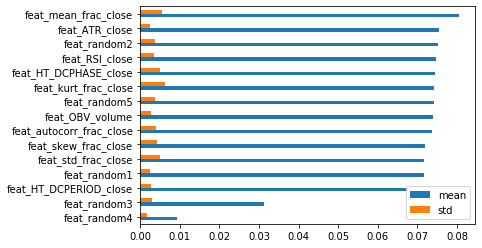

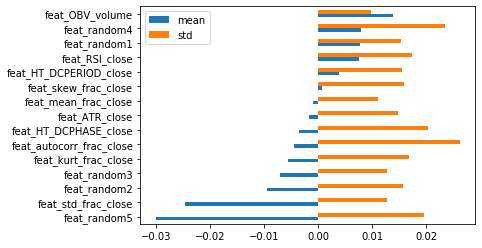

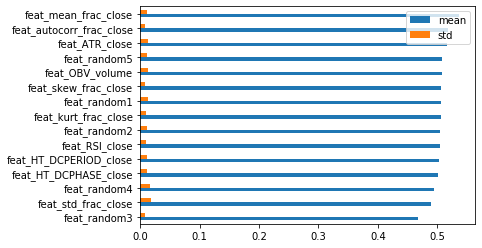

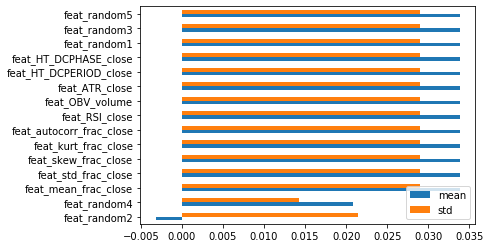

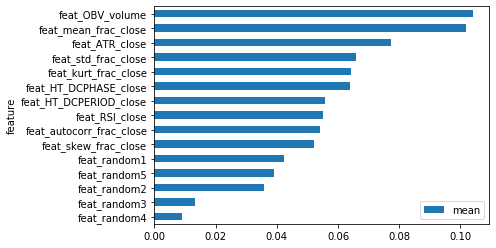

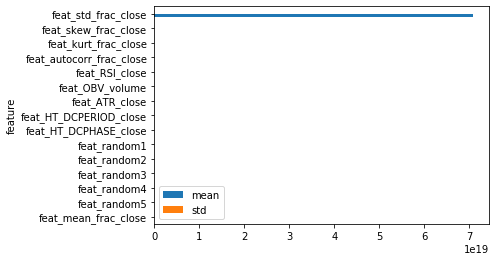

In [36]:
for name_i, importance_i in zip(dict0['method'], importances):
    print(name_i)
    importance_i.sort_values('mean').plot.barh()

In [37]:
from scipy.stats import weightedtau

In [38]:
weightedtau(importances[4]['mean'].values, importances[-1]['mean'].values**-1.)

WeightedTauResult(correlation=-0.10789805716617751, pvalue=nan)

# OOS evaluation

In [53]:
CUSTOM_IMPORTANT_FEATURES = [
    'feat_mean_frac_close', 
    'feat_OBV_volume', 
    'feat_kurt_frac_close', 
    'feat_ATR_close', 
    'feat_std_frac_close', 
    'feat_HT_DCPERIOD_close'
]

In [230]:
from sklearn.metrics import log_loss, f1_score, matthews_corrcoef, roc_auc_score

In [233]:
def cvScore2(clf,X,y,sample_weight,t1=None,cv=None,cvGen=None, pctEmbargo=None):

    if cvGen is None:
        cvGen = PurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo) # purged
        
    scores_f1, scores_mmc, scores_corr = [], [], []

    for train,test in cvGen.split(X=X):
        
        fit=clf.fit(X=X.iloc[train,:],y=y.iloc[train],
        sample_weight=sample_weight.iloc[train].values)
        
        pred = fit.predict(X.iloc[test,:])
        pred_p = fit.predict_proba(X.iloc[test,:])
        
        score_f1 = f1_score(y.iloc[test],pred,sample_weight=sample_weight.iloc[test].values)
        score_mmc = matthews_corrcoef(y.iloc[test],pred,sample_weight=sample_weight.iloc[test].values)
        score_corr = roc_auc_score(y.iloc[test],
                                    pred_p[:, 1],)
        
        scores_f1.append(score_f1)
        scores_mmc.append(score_mmc)
        scores_corr.append(score_corr)
        
    return np.array(scores_f1), np.array(scores_mmc), np.array(scores_corr)

In [234]:
res_all_f1, res_all_mmc, res_all_corr = [], [], []
res_normal_f1, res_normal_mmc, res_normal_corr = [], [], []

for i in range(100):
    lr = RandomForestClassifier()
    scores_f1, scores_mmc, scores_corr = cvScore2(lr, 
                     X_oos, 
                     Y_oos['bin'], Y_oos['w'], 
                     Y_oos['t1'], 
                     5, None, 0.05)
    res_all_f1.append(np.mean(scores_f1))
    res_all_mmc.append(np.mean(scores_mmc))
    res_all_corr.append(np.mean(scores_corr))

    lr = RandomForestClassifier()
    scores_f1, scores_mmc, scores_corr = cvScore2(lr, 
                     X_oos[CUSTOM_IMPORTANT_FEATURES], 
                     Y_oos['bin'], Y_oos['w'], 
                     Y_oos['t1'], 
                     5, None, 0.05)
    res_normal_f1.append(np.mean(scores_f1))
    res_normal_mmc.append(np.mean(scores_mmc))
    res_normal_corr.append(np.mean(scores_corr))

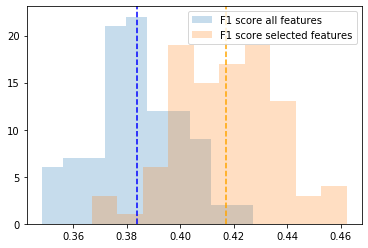

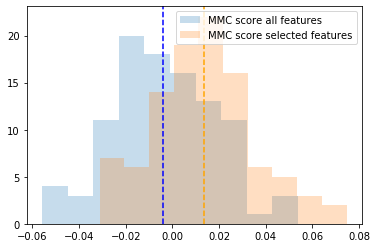

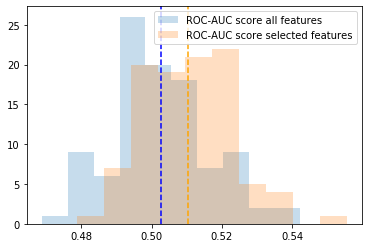

In [235]:
plt.figure()
plt.hist(res_all_f1, alpha = 0.25, label = 'F1 score all features')
plt.hist(res_normal_f1, alpha = 0.25, label = 'F1 score selected features')
plt.axvline(np.mean(res_all_f1), color = 'blue', ls = '--')
plt.axvline(np.mean(res_normal_f1), color = 'orange', ls = '--')
plt.legend()
plt.show()

plt.figure()
plt.hist(res_all_mmc, alpha = 0.25, label = 'MMC score all features')
plt.hist(res_normal_mmc, alpha = 0.25, label = 'MMC score selected features')
plt.axvline(np.mean(res_all_mmc), color = 'blue', ls = '--')
plt.axvline(np.mean(res_normal_mmc), color = 'orange', ls = '--')
plt.legend()
plt.show()

plt.figure()
plt.hist(res_all_corr, alpha = 0.25, label = 'ROC-AUC score all features')
plt.hist(res_normal_corr, alpha = 0.25, label = 'ROC-AUC score selected features')
plt.axvline(np.mean(res_all_corr), color = 'blue', ls = '--')
plt.axvline(np.mean(res_normal_corr), color = 'orange', ls = '--')
plt.legend()
plt.show()